# Gaussian Process for Event likelihoods

## Preliminary steps

### Loading necessary packages

In [1]:
using AugmentedGaussianProcesses
using Distributions
using Plots
default(msw=0.0, alpha=0.5, lw=3.0)

### Creating some random data
We first create some random data for the negative binomial problem
using the generative model

In [2]:
n_data = 200
x = (rand(n_data) .- 0.5) * 20
r = 5.0
y_bin = rand.(NegativeBinomial.(r, AGP.logistic.(-sin.(x))))

200-element Vector{Int64}:
 15
  9
  0
  4
  7
  3
  8
  6
  3
  2
  ⋮
 18
 13
  8
  6
  5
  2
  4
  1
  2

We use -sin because of the difference of definition between Wikipedia and Distributions.jl.
We do the same for the Poisson problem

In [3]:
λ = 10.0
y_poisson = rand.(Poisson.(λ * AGP.logistic.(sin.(x))))

200-element Vector{Int64}:
  4
  3
  3
  2
  9
  3
  7
  5
  2
  6
  ⋮
  7
 10
  2
  5
  5
  1
  1
  2
  5

And visualize the resulting data

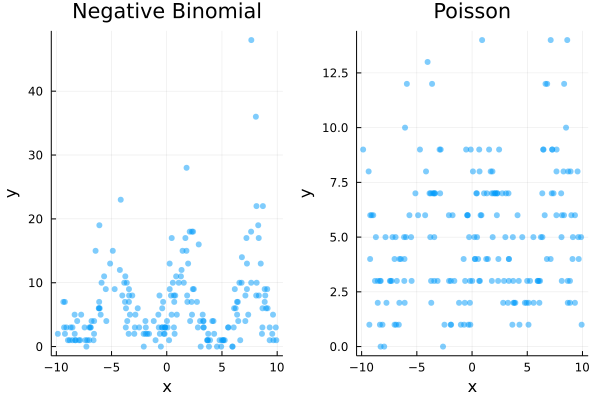

In [4]:
plot(
    scatter(x, y_bin; lab="", title="Negative Binomial"),
    scatter(x, y_poisson; lab="", title="Poisson");
    xlabel="x",
    ylabel="y"
)

## Initialization and training of the models
### Run GP model with negative binomial likelihood to learn p

In [5]:
kernel = with_lengthscale(SqExponentialKernel(), 1.0)
m_negbinomial = VGP(
    x, y_bin, kernel, NegBinomialLikelihood(r), AnalyticVI(); optimiser=false, verbose=2
)
@time train!(m_negbinomial, 5); # Train the model for 5 iterations

[ Info: Starting training Variational Gaussian Process with a Negative Binomial Likelihood (r = 5.0) infered by Analytic Variational Inference  with 200 samples, 1 features and 1 latent GP
[ Info: Training ended after 5 iterations. Total number of iterations 5
  1.073677 seconds (3.11 M allocations: 180.142 MiB, 98.26% compilation time)


### Running the same model but with the Poisson likelihood

In [6]:
kernel = with_lengthscale(SqExponentialKernel(), 1.0)
m_poisson = VGP(
    x, y_poisson, kernel, PoissonLikelihood(r), AnalyticVI(); optimiser=false, verbose=2
)
@time train!(m_poisson, 5);

[ Info: Starting training Variational Gaussian Process with a Poisson Likelihood (λ = 5.0) infered by Analytic Variational Inference  with 200 samples, 1 features and 1 latent GP
[ Info: Training ended after 5 iterations. Total number of iterations 5
  1.479970 seconds (3.70 M allocations: 226.661 MiB, 4.42% gc time, 98.78% compilation time)


## Prediction and plot function on a grid
Create a grid and compute predictive mean of `y` on it

In [7]:
function compute_pred_y_grid(model, n_grid=50)
    mins = -12
    maxs = 12
    x_grid = range(mins, maxs; length=n_grid) # Create a grid
    y_grid, sig_y_grid = proba_y(model, x_grid) # Predict the mean and variance on the grid
    return y_grid, sig_y_grid, x_grid
end

compute_pred_y_grid (generic function with 2 methods)

Create a grid and compute the predictive mean of `f` on it

In [8]:
function compute_pred_f_grid(model, n_grid=50)
    mins = -12
    maxs = 12
    x_grid = range(mins, maxs; length=n_grid) # Create a grid
    f_grid, f_var_grid = predict_f(model, x_grid; cov=true) # Predict the mean and variance on the grid
    return f_grid, f_var_grid, x_grid
end

compute_pred_f_grid (generic function with 2 methods)

Plot the data as a scatter plot

In [9]:
function plot_data(x, y)
    return Plots.scatter(x, y; lab="", size=(800, 500))
end

function plot_f(model)
    f, f_var, x_grid = compute_pred_f_grid(model, 100)
    plot(x_grid, sin; lab="sin", title="Latent f")
    plot!(x_grid, f; ribbon=2 * sqrt.(f_var), lab="f")
end

function plot_y(model, x, y_bin)
    pred_y, pred_y_var, x_grid = compute_pred_y_grid(model, 100)
    true_p_y = model.likelihood.(sin.(x_grid))
    true_y, true_var_y = mean.(true_p_y), var.(true_p_y)
    plot_data(x, y_bin)
    plot!(x_grid, true_y; ribbon=2 * sqrt.(true_var_y), lab="true p(y|f)", title="Expectation of y")
    plot!(x_grid, pred_y; ribbon=2 * sqrt.(pred_y_var), label="pred p(y|f)")
end

plot_y (generic function with 1 method)

## Plotting the comparison results

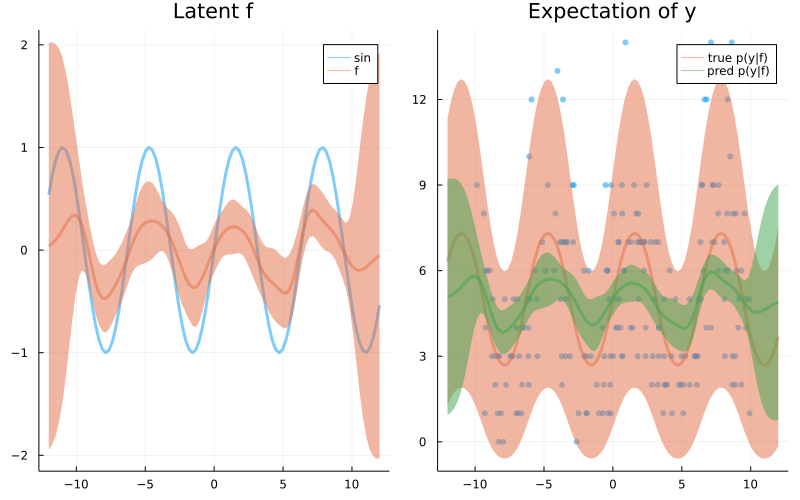

In [10]:
# We first compare the results for the Negative Binomial likelihood
plot(
    plot_f(m_negbinomial),
    plot_y(m_negbinomial, x, y_bin)
)
# And we do the same for the Poisson likelihood
plot(
    plot_f(m_poisson),
    plot_y(m_poisson, x, y_poisson)
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*